In [6]:
# My clustering method with K-means was not promising enough. Looking at the data summary again I want to go ahead with another clustering
# chance. For the second try I will cluster the salary in usd and analyse how the algorithm will cluster the salary and then compare the 
# job salary categories with the one from switzerland. 
import csv 
import pandas as pd 
df = pd.read_csv('data_science_job.csv')

In [7]:
df[['job_title', 'job_category', 'salary', 'salary_in_usd']].describe(include='all')


,job_title,job_category,salary,salary_in_usd
count,5000,4500,5000.000000,5000.000000
unique,15,4,NaN,NaN
top,Data Engineer in office,Data Science,NaN,NaN
freq,372,1173,NaN,NaN
mean,NaN,NaN,102046.307200,114076.995800
std,NaN,NaN,70853.626492,49113.807687
min,NaN,NaN,-198754.000000,30016.000000
25%,NaN,NaN,64295.500000,71343.750000
50%,NaN,NaN,110636.000000,114167.000000
75%,NaN,NaN,153104.750000,156665.750000


In [9]:
print(df['salary_in_usd'].min())
print(df['salary_in_usd'].max())

30016
199985


In [10]:
NA_salary = df['salary_in_usd'].isna().sum()
NA_any = df.isna().any().any() 

print(NA_salary)
print(NA_any) # there are no NA's

0
True


In [11]:
# now I'll use the elbow method and silhouette score to find optimal numbers of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_sal = df[['salary_in_usd']]
sse = []
silhouette = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sal)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_sal, kmeans.labels_))

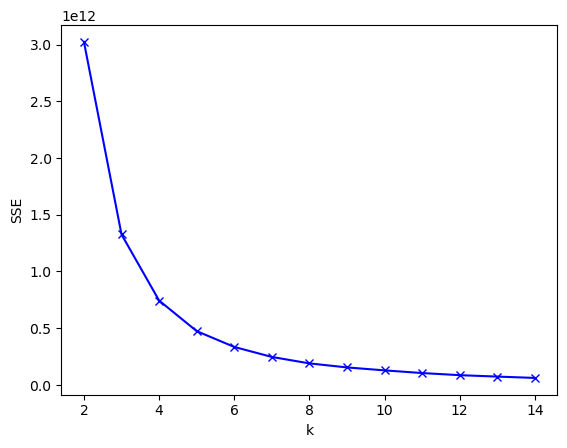

In [13]:
# plot the results
import matplotlib.pyplot as plt
import seaborn as sns
# SSE (Elbow method)
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
#plt.title('Elbow Method For Optimal k')
plt.savefig('Elbow Method For Optimal k.png', bbox_inches='tight')

plt.show()

# it seems that the elbow is around 3 to 5 with the optimal number of 4

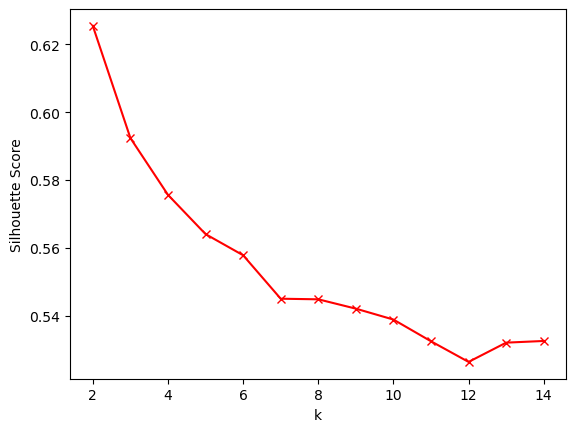

In [17]:
# Plot Silhouette Score
plt.plot(K, silhouette, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
#plt.title('Silhouette Score for k')
plt.savefig('Silhouette Score for k.png', bbox_inches='tight')

plt.show()

# in general the clustering is showing a good result since it's score is above 0.5. A clustering between 3 and 5 seems good. A great point is number 4 
# since the elbow method also suggested k = 4

In [18]:
# apply the significant k-mean 
best_k_salary = 4
kmeans = KMeans(n_clusters=best_k_salary, random_state=42)
#df_jobs['cluster'] = kmeans.fit_predict(X)
label = kmeans.fit_predict(X_sal)
print(len(label))

5000


In [19]:
# now let's check the job salaries per clusters
for i in range(best_k_salary):
    print(f"\nCluster {i} top salary:")
    print(df[label == i]['salary_in_usd'].value_counts(sort=True))


Cluster 0 top salary:
salary_in_usd
158161    2
170921    2
175213    2
186295    2
164940    2
         ..
155462    1
166433    1
197174    1
172081    1
172425    1
Name: count, Length: 1263, dtype: int64

Cluster 1 top salary:
salary_in_usd
70916     2
95355     2
96500     2
107952    2
76335     2
         ..
86414     1
109951    1
86889     1
82483     1
100031    1
Name: count, Length: 1218, dtype: int64

Cluster 2 top salary:
salary_in_usd
53115    2
59018    2
45316    2
63208    2
31316    2
        ..
49329    1
41369    1
40916    1
53265    1
51366    1
Name: count, Length: 1190, dtype: int64

Cluster 3 top salary:
salary_in_usd
129427    2
147503    2
114614    2
141902    2
138407    2
         ..
112209    1
144576    1
127204    1
134262    1
153825    1
Name: count, Length: 1256, dtype: int64


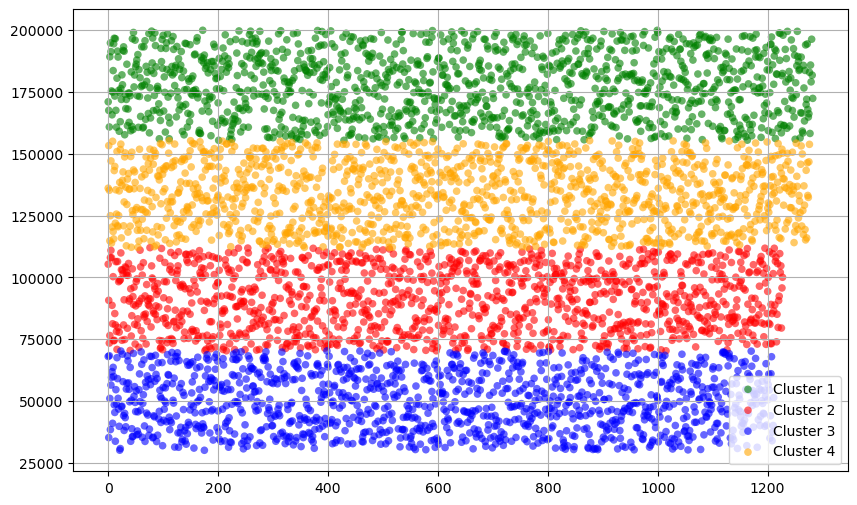

In [20]:
# let's plot it in a scatterplot of my clustering. 

from sklearn.decomposition import PCA

#pca = PCA(n_components=2)
#X_2d = pca.fit_transform(X_sal)  #PCA is not needed as salary is one numarical variable

# Plot the clusters
plt.figure(figsize=(10, 6))
colors = ['green', 'red', 'blue', 'orange']
for i in range(best_k_salary):
    plt.scatter(
        range(len(X_sal[label == i])),  # just plot index on x-axis
        X_sal[label == i],
        s=30,
        c=colors[i % len(colors)],
        label=f'Cluster {i + 1}',
        alpha=0.6,
        edgecolors='none'
    )

#plt.title('Visualization of KMeans Clusters (Salary in USD)')
plt.legend()
plt.grid(True)
plt.savefig('Visualization of KMeans Clusters.png', bbox_inches='tight')

plt.show()

In [21]:
# Let's cluster based on both job salary and job titles and find out where the highest-paid jobs are.
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Scale salary
scaler = StandardScaler()
salary_scaled = scaler.fit_transform(df[['salary_in_usd']])

# I have to vectorize job titles since it's text 
vectorizer = TfidfVectorizer(max_features=100)  
job_title_vectors = vectorizer.fit_transform(df['job_title'])

# combine salary and job title vectors
from scipy.sparse import hstack
X_combined = hstack([salary_scaled, job_title_vectors])  # is a sparse matrix

# Cluster
best_k_salary = 4  
kmeans = KMeans(n_clusters=best_k_salary, random_state=42)
kmeans.fit(X_combined)

# add cluster labels back to df
df['cluster'] = kmeans.labels_

# analyze clusters by salary
cluster_salary = df.groupby('cluster')['salary_in_usd'].agg(['mean', 'max', 'min', 'count']).reset_index()
print(cluster_salary)

# here I noticed that two clusters have the same maximum. if two people earn similar high salaries, but their job titles are different enough,
# the clustering algorithm may put them in different clusters.

   cluster           mean     max     min  count
0        0  165764.578065  199964  126320    775
1        1   56616.497528   85669   30016   1618
2        2  168979.395154  199985  135812   1073
3        3  110167.566493  138906   83092   1534


In [22]:
# check which job titles are the most paid per cluster
top_clusters = cluster_salary.sort_values('mean', ascending=True)


# Inspect job titles in those clusters
for cluster_id in top_clusters['cluster']:
    print(f"\nTop job titles in cluster {cluster_id}:")
    print(df[df['cluster'] == cluster_id]['job_title'].value_counts())

# In some clusters there are more and less jobs. They differe also per count. 


Top job titles in cluster 1:
job_title
Data Engineer  in office                125
Machine Learning Engineer               121
Data Analyst  (Remote)                  119
Data Scientist                          117
Statistician                            114
Machine Learning Engineer  in office    113
Data Engineer                           111
Machine Learning Engineer  (Remote)     106
Data Analyst  in office                 106
Data Scientist  (Remote)                105
Data Scientist  in office               104
Statistician  (Remote)                  100
Data Engineer  (Remote)                 100
Statistician  in office                  90
Data Analyst                             87
Name: count, dtype: int64

Top job titles in cluster 3:
job_title
Data Engineer  in office                130
Data Analyst                            126
Data Engineer  (Remote)                 119
Data Engineer                           115
Statistician  (Remote)                  111
Data Scientist

In [23]:
# here I want to create a dataframe of the upper code:
# empty list to count the data
job_title_summary = []

# Sort clusters by average salary
top_clusters = cluster_salary.sort_values('mean', ascending=True)

# Loop through each cluster
for cluster_id in top_clusters['cluster']:
    cluster_data = df[df['cluster'] == cluster_id]
    job_titles = cluster_data['job_title'].unique()
    
    for title in job_titles:
        title_data = cluster_data[cluster_data['job_title'] == title]
        count = len(title_data)
        max_salary = title_data['salary_in_usd'].max()
        avg_salary = title_data['salary_in_usd'].mean()
        min_salary = title_data['salary_in_usd'].min()
        
        job_title_summary.append({
            'cluster': cluster_id,
            'job_title': title,
            'count': count,
            'max_salary': max_salary,
            'min_salary': min_salary
        })

# Convert to DataFrame
job_cluster_df = pd.DataFrame(job_title_summary)

# Optional: Sort by cluster and max_salary
job_cluster_df = job_cluster_df.sort_values(['cluster', 'count', 'max_salary', 'min_salary'], ascending=[True, False, True, False])

# Show top rows
print(job_cluster_df)





    cluster                             job_title  count  max_salary  \
34        0   Machine Learning Engineer  (Remote)    159      198996   
30        0  Machine Learning Engineer  in office    132      199734   
35        0                       Data Engineer      129      199640   
33        0               Data Engineer  (Remote)    119      198115   
31        0           Machine Learning Engineer      119      199024   
32        0              Data Engineer  in office    117      199964   
7         1              Data Engineer  in office    125       82772   
2         1           Machine Learning Engineer      121       85669   
9         1                Data Analyst  (Remote)    119       82233   
3         1                      Data Scientist      117       82900   
1         1                        Statistician      114       82483   
8         1  Machine Learning Engineer  in office    113       84969   
5         1                       Data Engineer      111       8

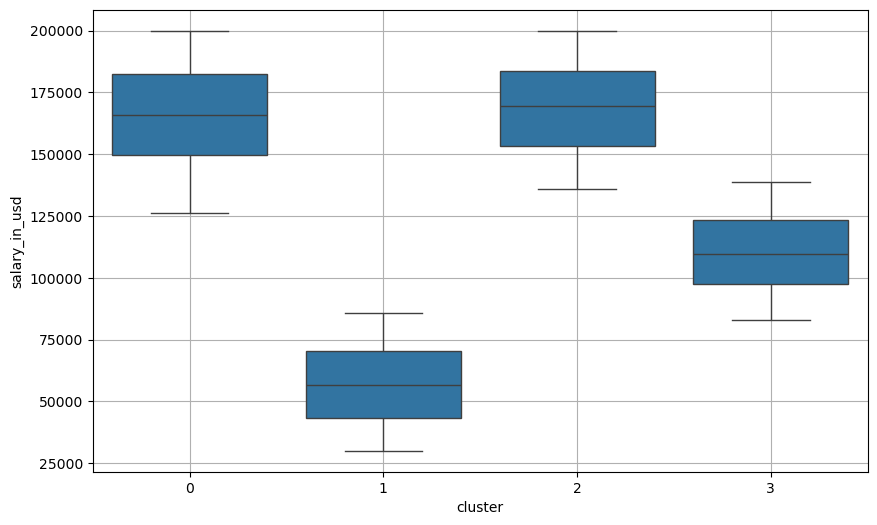

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='salary_in_usd', data=df)
#plt.title("Salary Distribution per Cluster")
plt.grid(True)
plt.savefig('salary distribution per cluster.png', bbox_inches='tight')

plt.show()

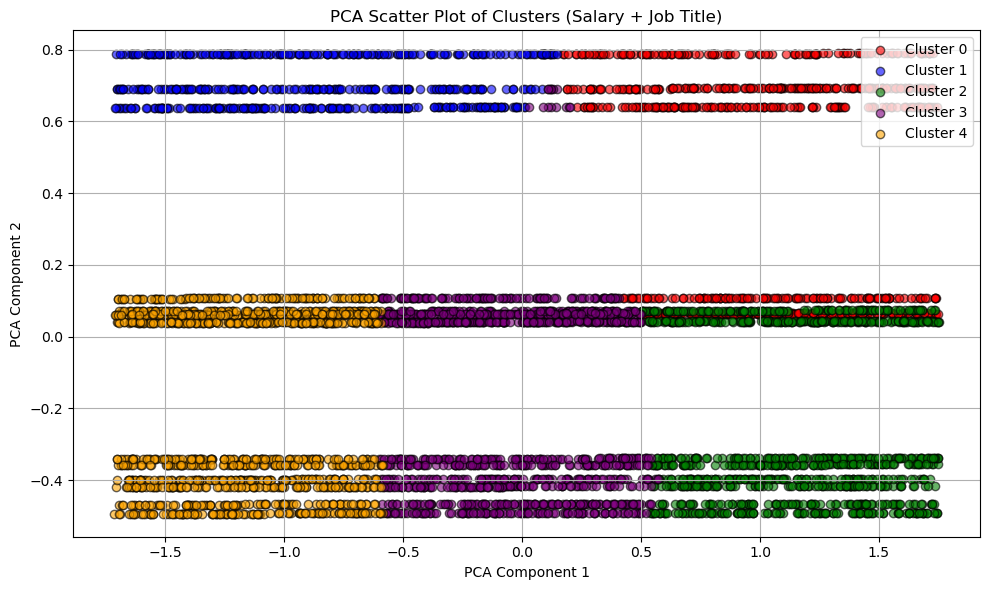

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert sparse matrix to dense
X_dense = X_combined.toarray()

# Reduce to 2D with PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)

# Plot clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green', 'purple', 'orange']

for i in range(best_k_salary):
    plt.scatter(
        X_pca[df['cluster'] == i, 0],
        X_pca[df['cluster'] == i, 1],
        label=f'Cluster {i}',
        alpha=0.6,
        c=colors[i % len(colors)],
        edgecolor='k'
    )

plt.title('PCA Scatter Plot of Clusters (Salary + Job Title)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
